<a href="https://colab.research.google.com/github/kareem1925/Ismailia-school-of-AI/blob/master/machine%20learning%20for%20classifying%20quantum%20states/pennylane-quantum-state-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will start by configuring the environment and install the libraries we need.

In [0]:
!pip install pennylane --upgrade
# it's important to restart the runtime so that pennylane works fine
import os
os.kill(os.getpid(), 9)

     |████████████████████████████████| 204kB 4.8MB/s 
  Found existing installation: semantic-version 2.8.4
    Uninstalling semantic-version-2.8.4:
      Successfully uninstalled semantic-version-2.8.4


In [1]:
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt
print(qml.about())
np.set_printoptions(precision=20)
plt.style.use("seaborn-paper")

Name: PennyLane
Version: 0.8.1
Summary: PennyLane is a Python quantum machine learning library by Xanadu Inc.
Home-page: https://github.com/XanaduAI/pennylane
Author: None
Author-email: None
License: Apache License 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: networkx, numpy, toml, scipy, semantic-version, appdirs, autograd
Required-by: 
Platform info:           Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic
Python version:          3.6.9
Numpy version:           1.17.5
Scipy version:           1.4.1
Installed devices:
- default.gaussian (PennyLane-0.8.1)
- default.qubit (PennyLane-0.8.1)
- default.tensor (PennyLane-0.8.1)
- default.tensor.tf (PennyLane-0.8.1)
None


### Quantum node initialization


*   It's important to set analytic to False.
*   The quantum layer consists of only one parameterized gate $R_y$ and a $CNOT$ because:

  $\displaystyle R_\phi = e^{-i\frac{\phi_y}{2}} = \begin{bmatrix} cos(\frac{\phi}{2}) & -sin(\frac{\phi}{2}) \\ sin(\frac{\phi}{2}) & cos(\frac{\phi}{2}) \end{bmatrix}$ 
    
  so that a value of $\pi/2$ will result in a Hadamard gate:
  
  $\displaystyle H = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}$ 

*   The above will result in an entangled state: $ \left | \psi  \right \rangle$ $=$ $\frac{1}{\sqrt{2}} \left (\left | 00  \right \rangle + \left | 11  \right \rangle  \right )$



In [0]:
# the number of shots will be varied during the notebook
dev1 = qml.device('default.qubit',wires=2,analytic=False,shots=1000)

@qml.qnode(dev1)
def circuit(params):

    qml.RY(params[0],wires=0)
    qml.CNOT(wires=[0,1])
    return qml.expval(qml.Hermitian(H,wires=[0,1]))



*   The most important thing in our circuit is the observable that we will measure. Pennylane offers us a way to do that by computing an arbitrary observable. 
*   By computing the density matrix $\rho = |\psi\rangle\langle\psi|$ we can use it directly as the Hermitian obervable $A$.
$\langle A\rangle = \langle \psi|A|\psi\rangle$


In [115]:
y = np.array([1/np.sqrt(2),0,0,1/np.sqrt(2)])
H = np.outer(y,y)
print(circuit([np.pi/2]))

# verifying 

state = dev1.state
abs(state.conj().T.dot(H).dot(state))

0.9999999999999999


0.9999999999999998

In [0]:
# this loss function is used for dealing with probabilities
def cross_entropy(predictions, targets, epsilon=1e-20):
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log10(predictions+epsilon))/N
    return ce

### Creating cost fucntion

In [0]:
ground_labels = np.array([0.5,0,0,0.5])

def cost(var):
#    return cross_entropy(circuit(var),la) if i'm going to use probs value form qnode
    return abs(1 - circuit(var))

### Weight initialization

In [118]:
np.random.seed(1000)
init_params = np.random.rand(1) 
print(init_params)
print(cost(init_params))

[0.6535895854646095]
0.22000000000000008


## Training section

this cell will run the quantum circuits with $1000$ shots

In [119]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

# set the number of steps
steps = 2000
# set the initial parameter values
params = init_params
dev1.shots = 1000
dev1.analytic = False

cost1000 = []
for i in range(steps):
    # update the circuit parameters
    params = opt.step(cost, params)
    t = cost(params)
    cost1000.append(t)

    if (i + 1) % 100 == 0:
        print("Cost after step {:5d}: {: .30f}".format(i + 1, t))

print("Optimized rotation angles: {}".format(params))
final_1000 = params 

Cost after step   100:  0.000000000000000111022302462516
Cost after step   200:  0.000000000000000111022302462516
Cost after step   300:  0.000000000000000111022302462516
Cost after step   400:  0.000000000000000111022302462516
Cost after step   500:  0.000000000000000111022302462516
Cost after step   600:  0.000000000000000111022302462516
Cost after step   700:  0.000000000000000111022302462516
Cost after step   800:  0.000000000000000111022302462516
Cost after step   900:  0.000000000000000111022302462516
Cost after step  1000:  0.000000000000000111022302462516
Cost after step  1100:  0.000000000000000111022302462516
Cost after step  1200:  0.000000000000000111022302462516
Cost after step  1300:  0.000000000000000111022302462516
Cost after step  1400:  0.000000000000000111022302462516
Cost after step  1500:  0.000000000000000111022302462516
Cost after step  1600:  0.000000000000000111022302462516
Cost after step  1700:  0.000000000000000111022302462516
Cost after step  1800:  0.00000

**$100$ shots** for this cell

In [120]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

# set the number of steps
steps = 2000
# set the initial parameter values
params = init_params
dev1.shots = 100
dev1.analytic = False
cost100 = []
for i in range(steps):
    # update the circuit parameters
    params = opt.step(cost, params)
    t = cost(params)
    cost100.append(t)

    if (i + 1) % 100 == 0:
        print("Cost after step {:5d}: {: .30f}".format(i + 1, t))

print("Optimized rotation angles: {}".format(params))
final_100 = params

Cost after step   100:  0.000000000000000111022302462516
Cost after step   200:  0.000000000000000111022302462516
Cost after step   300:  0.000000000000000111022302462516
Cost after step   400:  0.000000000000000111022302462516
Cost after step   500:  0.000000000000000111022302462516
Cost after step   600:  0.000000000000000111022302462516
Cost after step   700:  0.000000000000000111022302462516
Cost after step   800:  0.000000000000000111022302462516
Cost after step   900:  0.000000000000000111022302462516
Cost after step  1000:  0.000000000000000111022302462516
Cost after step  1100:  0.000000000000000111022302462516
Cost after step  1200:  0.000000000000000111022302462516
Cost after step  1300:  0.000000000000000111022302462516
Cost after step  1400:  0.000000000000000111022302462516
Cost after step  1500:  0.000000000000000111022302462516
Cost after step  1600:  0.000000000000000111022302462516
Cost after step  1700:  0.000000000000000111022302462516
Cost after step  1800:  0.00000

**$10$ shots**

In [121]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

# set the number of steps
steps = 2000
# set the initial parameter values
params = init_params
dev1.shots = 10
dev1.analytic = False
cost10 = []
for i in range(steps):
    # update the circuit parameters
    params = opt.step(cost, params)
    t = cost(params)
    cost10.append(t)

    if (i + 1) % 100 == 0:
        print("Cost after step {:5d}: {: .30f}".format(i + 1, t))

print("Optimized rotation angles: {}".format(params))
final_10 = params

Cost after step   100:  0.000000000000000222044604925031
Cost after step   200:  0.000000000000000222044604925031
Cost after step   300:  0.000000000000000222044604925031
Cost after step   400:  0.000000000000000222044604925031
Cost after step   500:  0.000000000000000222044604925031
Cost after step   600:  0.000000000000000222044604925031
Cost after step   700:  0.000000000000000222044604925031
Cost after step   800:  0.000000000000000222044604925031
Cost after step   900:  0.000000000000000222044604925031
Cost after step  1000:  0.000000000000000222044604925031
Cost after step  1100:  0.000000000000000222044604925031
Cost after step  1200:  0.000000000000000222044604925031
Cost after step  1300:  0.000000000000000222044604925031
Cost after step  1400:  0.000000000000000222044604925031
Cost after step  1500:  0.000000000000000222044604925031
Cost after step  1600:  0.000000000000000222044604925031
Cost after step  1700:  0.000000000000000222044604925031
Cost after step  1800:  0.00000

**only $1$ shot**

In [122]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

# set the number of steps
steps = 2000
# set the initial parameter values
params1 = init_params
dev1.shots = 1
dev1.analytic = False
cost1 = []
for i in range(steps):
    # update the circuit parameters
    params1 = opt.step(cost, params1)
    t = cost(params1)
    cost1.append(t)

    if (i + 1) % 100 == 0:
        print("Cost after step {:5d}: {: .30f}".format(i + 1, t))

print("Optimized rotation angles: {}".format(params1))
final_1 = params

Cost after step   100:  0.000000000000000222044604925031
Cost after step   200:  0.000000000000000222044604925031
Cost after step   300:  0.000000000000000222044604925031
Cost after step   400:  0.000000000000000222044604925031
Cost after step   500:  0.000000000000000222044604925031
Cost after step   600:  0.000000000000000222044604925031
Cost after step   700:  0.000000000000000222044604925031
Cost after step   800:  0.000000000000000222044604925031
Cost after step   900:  0.000000000000000222044604925031
Cost after step  1000:  0.000000000000000222044604925031
Cost after step  1100:  0.000000000000000222044604925031
Cost after step  1200:  0.000000000000000222044604925031
Cost after step  1300:  0.000000000000000222044604925031
Cost after step  1400:  0.000000000000000222044604925031
Cost after step  1500:  0.000000000000000222044604925031
Cost after step  1600:  0.000000000000000222044604925031
Cost after step  1700:  0.000000000000000222044604925031
Cost after step  1800:  0.00000

**Analytical simulation**

In [123]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

# set the number of steps
steps = 1000
# set the initial parameter values
params = init_params
dev1.shots = 1024
dev1.analytic = True

cost_analytic = []
for i in range(steps):
    # update the circuit parameters
    params = opt.step(cost, params)
    t = cost(params)
    cost_analytic.append(t)

    if (i + 1) % 100 == 0:
        print("Cost after step {:5d}: {: .30f}".format(i + 1, t))

print("Optimized rotation angles: {}".format(params))
final = params

Cost after step   100:  0.000008643152367482365150408441
Cost after step   200:  0.000000000302968539145354043285
Cost after step   300:  0.000000000000011102230246251565
Cost after step   400:  0.000000000000000444089209850063
Cost after step   500:  0.000000000000000444089209850063
Cost after step   600:  0.000000000000000444089209850063
Cost after step   700:  0.000000000000000444089209850063
Cost after step   800:  0.000000000000000444089209850063
Cost after step   900:  0.000000000000000444089209850063
Cost after step  1000:  0.000000000000000444089209850063
Optimized rotation angles: [1.5707963267948943]


### Plotting the training history

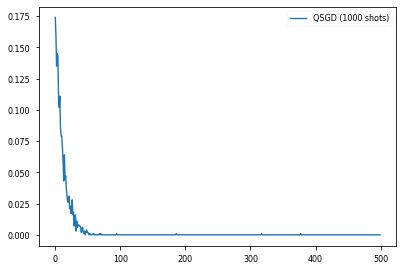

In [124]:
plt.plot(cost1000[:500] ,label="QSGD (1000 shots)")
plt.legend()

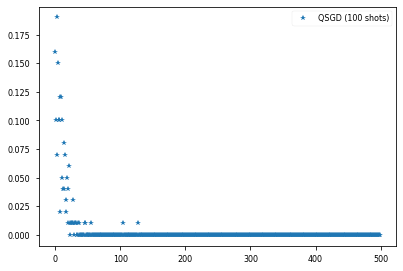

In [125]:
plt.plot(cost100[:500], "*", label="QSGD (100 shots)")
plt.legend()

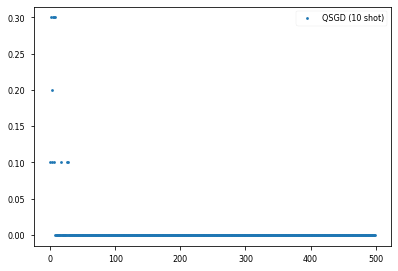

In [126]:
plt.plot(cost10[:500],".", label="QSGD (10 shot)")
plt.legend()

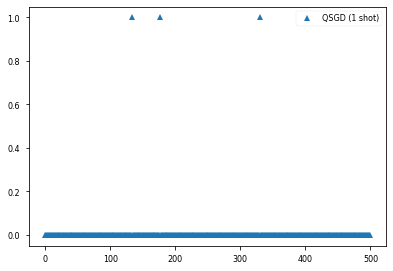

In [127]:
plt.plot(cost1[:500],"^", label="QSGD (1 shot)")
plt.legend()

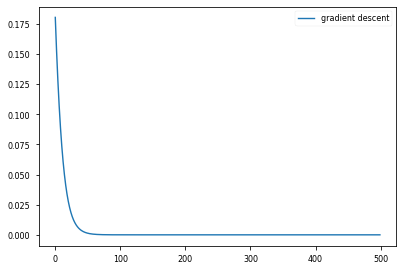

In [128]:
plt.plot(cost_analytic[:500],"-", label="gradient descent")
plt.legend()

The lowest value for each simulation

In [136]:
print("1000 shots = ",cost1000[np.argmin(cost1000)], ' iter value is ', np.argmin(cost1000))
print("100 shots = ",cost100[np.argmin(cost100)], ' iter value is ', np.argmin(cost100))
print("10 shots = ",cost10[np.argmin(cost10)], ' iter value is ', np.argmin(cost10))
print("1 shots = ",cost1[np.argmin(cost1)], ' iter value is ', np.argmin(cost1))
print("Analytic = ",cost_analytic[np.argmin(cost_analytic)], ' iter value is ', np.argmin(cost_analytic))

1000 shots =  1.1102230246251565e-16  iter value is  46
100 shots =  1.1102230246251565e-16  iter value is  22
10 shots =  2.220446049250313e-16  iter value is  8
1 shots =  2.220446049250313e-16  iter value is  0
Analytic =  2.220446049250313e-16  iter value is  357


In [111]:
# values of the final weights
final,final_1000,final_100,final_10,final_1

(array([1.5707963267948943]),
 array([1.571308958546461]),
 array([1.5733589585464625]),
 array([1.610358958546463]),
 array([1.610358958546463]))